**Student Name: Bakhtiyor Sohibnazarov** \
**Student ID: SOH22590018** \
**Course: Computer Science. Artificial Intelligence Module** \
**Purpose: Coursework - 2** \
**Last Update: 26.03.2025**

## CourseWork - 2. Sustainable Transportation Solutions
#### Task 1: Define the Map
10 UK cities **(Manchester,
Holyhead, Liverpool, York, Carlisle, Newcastle, Glasgow, Edinburgh, Oban, Aberdeen,
Inverness)** are used as delivery nodes. The Graph will have weight with actual road distances.
This task sets up the transportation environment using a graph structure where cities are nodes, and roads are weighted edges. Traffic conditions affect road distances, and the environment uses these factors to compute travel times. The map also includes city coordinates for visualization.


In [36]:
# Import Dependencies. NetworkX for graph. Plotly for Map Visualization
import networkx as nx
import plotly.graph_objects as go
from collections import deque

# Class to represent the Environment
class Environment:
    def __init__(self):
        # Creates Graph. Stores actual graph. Can be modifies within the class
        self.graph = nx.Graph()
        
        # Declaration of City Coordinates
        self.city_coordinates = {
            'Manchester': (53.4808, -2.2426),
            'Liverpool': (53.4084, -2.9916),
            'Holyhead': (53.3097, -4.6332),
            'York': (53.9590, -1.0815),
            'Carlisle': (54.8925, -2.9329),
            'Newcastle': (54.9783, -1.6178),
            'Glasgow': (55.8642, -4.2518),
            'Edinburgh': (55.9533, -3.1883),
            'Oban': (56.4152, -5.4716),
            'Aberdeen': (57.1497, -2.0943),
            'Inverness': (57.4778, -4.2247)
        }
        
        # Builds Graph
        self._build_graph()
        
        # Static traffic factor
        self._apply_traffic_factors()

    def _build_graph(self):
        """Build the graph from the adjacency list."""
        
        map_graph = {
            'Manchester': {'Liverpool': 40, 'York': 60, 'Newcastle': 130, 'Edinburgh': 220, 'Carlisle': 120},
            'Liverpool': {'Manchester': 40, 'Holyhead': 90},
            'Holyhead': {'Liverpool': 90},
            'York': {'Manchester': 60, 'Newcastle': 80},
            'Carlisle': {'Manchester': 120, 'Glasgow': 100},
            'Newcastle': {'Manchester': 130, 'York': 80, 'Edinburgh': 110},
            'Glasgow': {'Carlisle': 100, 'Edinburgh': 40, 'Oban': 90, 'Aberdeen': 140, 'Inverness': 170},
            'Edinburgh': {'Newcastle': 110, 'Glasgow': 40, 'Manchester': 220},
            'Oban': {'Glasgow': 90, 'Inverness': 110},
            'Aberdeen': {'Glasgow': 140, 'Inverness': 110},
            'Inverness': {'Oban': 110, 'Aberdeen': 110, 'Glasgow': 170}
        }
        
        # For loop that Modifies created NetworkX graph.
        for city, neighbors in map_graph.items():
            for neighbor, dist in neighbors.items():
                self.graph.add_edge(city, neighbor, weight=dist)
                
        for city, coords in self.city_coordinates.items():
            self.graph.nodes[city]['pos'] = coords

        # Store original distances separately
        self.original_distances = {}
        for u, v, data in self.graph.edges(data=True):
            self.original_distances[(u, v)] = data['weight']
            self.original_distances[(v, u)] = data['weight']

    def _apply_traffic_factors(self):
        """Apply static traffic factors to edges."""
        # Define static traffic factors for specific edges
        # 1 - No Traffic
        # 1.2 - Light Traffic
        # 1.4 - Moderate Traffic
        # 1.6 - Heavy Traffic
        # 1.8 - Severe Traffic
    
        # Traffic factors with consistent ordering for edges
        self.traffic_factors = {
            tuple(sorted(['Manchester', 'Liverpool'])): 1.0,
            tuple(sorted(['Manchester', 'York'])): 1.0,
            tuple(sorted(['Manchester', 'Newcastle'])): 1.0,
            tuple(sorted(['Manchester', 'Edinburgh'])): 1.0,
            tuple(sorted(['Manchester', 'Carlisle'])): 1.0,
            tuple(sorted(['Liverpool', 'Holyhead'])): 1.0,
            tuple(sorted(['York', 'Newcastle'])): 1.0,
            tuple(sorted(['Carlisle', 'Glasgow'])): 1.0,
            tuple(sorted(['Newcastle', 'Edinburgh'])): 1.0,
            tuple(sorted(['Glasgow', 'Edinburgh'])): 1.0,
            tuple(sorted(['Oban', 'Inverness'])): 1.0,
            tuple(sorted(['Aberdeen', 'Inverness'])): 1.0,
            tuple(sorted(['Glasgow', 'Inverness'])): 1.0,
            tuple(sorted(['Glasgow', 'Aberdeen'])): 1.0
        }

    
        # Apply traffic factors to edges. Modify defined graph.
        for (u, v), factor in self.traffic_factors.items():
            
            # Ensure we are storing edges consistently as (min(u, v), max(u, v))
            ordered_edge = (min(u, v), max(u, v))
    
            # Check if the edge exists in the graph and apply the factor
            if self.graph.has_edge(ordered_edge[0], ordered_edge[1]):
                self.graph[ordered_edge[0]][ordered_edge[1]]['weight'] *= factor

    # Returns nodes
    def get_cities(self):
        """Return a list of cities."""
        return list(self.graph.nodes())

    # Returns city coordinates
    def get_city_coordinates(self, city):
        """Return the coordinates of a city."""
        return self.city_coordinates.get(city, (0, 0))

    def calculate_path_distance(self, path):
        """Calculate the total distance of a path, considering traffic factors."""
        total_distance = 0
        max_traffic_factor = 1.0
        
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
    
            # Normalize the edge to handle undirected graph (min(u, v), max(u, v))
            ordered_edge = (min(u, v), max(u, v))
            
            if self.graph.has_edge(u, v):
                edge_weight = self.graph[u][v]['weight']
                total_distance += edge_weight
    
                # Get the traffic factor for the normalized edge
                traffic_factor = self.traffic_factors.get(ordered_edge, 1.0)
                max_traffic_factor = max(max_traffic_factor, traffic_factor)
            else:
                return None  # No edge exists between these nodes
    
        return total_distance, max_traffic_factor


#### Task 2: Define the Searching Algorithms

We implement four search algorithms:
- **Dijkstra's Algorithm**: Finds the shortest path based on traffic-adjusted distances.
- **A(*) Algorithm**: Uses heuristics to guide the search towards the goal city.
- **BFS**: Explores neighbors level by level in an unweighted graph.
- **DFS**: Explores the graph depth-first before backtracking.


In [38]:
# Class to represent the Agent (Pathfinding)
class Search:
    def __init__(self, environment):
        self.env = environment
        
    # Apply NetworkX builtin Djikstra Algorithm. Returns Path
    def dijkstra(self, start, end):
        """Find the shortest path using Dijkstra's algorithm."""
        try:
            path = nx.dijkstra_path(self.env.graph, source=start, target=end, weight='weight')
            return path
        except nx.NetworkXNoPath:
            return None

    # Apply NetworkX builtIn A-start algorithm, Need to specify heuristic.
    def astar(self, start, end):
        """Find the shortest path using A* algorithm."""
        def heuristic(node, goal):
            # Euclidean distance as heuristic
            return ((self.env.city_coordinates[node][0] - self.env.city_coordinates[goal][0]) ** 2 +
                    (self.env.city_coordinates[node][1] - self.env.city_coordinates[goal][1]) ** 2) ** 0.5
        try:
            # Returns Path to the target
            return nx.astar_path(self.env.graph, source=start, target=end, heuristic=heuristic, weight='weight')
        except nx.NetworkXNoPath:
            return None

    # Implemented manually as builtIn Function of NetworkX does not support weighted graphs
    def bfs(self, start, end):
        """Find a path using Breadth-First Search (manually implemented)."""
        if start == end:
            return [start]

        visited = set()
        queue = deque()
        queue.append((start, [start]))  # (current_node, path)

        while queue:
            current_node, path = queue.popleft()
            visited.add(current_node)

            for neighbor in self.env.graph.neighbors(current_node):
                if neighbor == end:
                    return path + [neighbor]
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))

        return None  # No path found

    # Implemented manually as builtIn Function of NetworkX does not support weighted graphs
    def dfs(self, start, end):
        """Find a path using Depth-First Search (manually implemented)."""
        if start == end:
            return [start]

        visited = set()
        stack = [(start, [start])]  # (current_node, path)

        while stack:
            current_node, path = stack.pop()
            visited.add(current_node)

            for neighbor in self.env.graph.neighbors(current_node):
                if neighbor == end:
                    return path + [neighbor]
                if neighbor not in visited:
                    visited.add(neighbor)
                    stack.append((neighbor, path + [neighbor]))

        return None  # No path found

#### Task 3: Show the results
This task visualizes the search results, showing the optimal path, total distance, traffic conditions, ETA, and carbon emissions for different vehicles. The paths are displayed on a map with road conditions highlighted.

In [40]:

def visualize_path(environment, path, algorithm_name):
    """Visualize the path on a map using Plotly and print carbon emissions."""
    if path is None:
        print(f"No path found for {algorithm_name}.")
        return

    # Emission factors (in kg/mile)
    EMISSION_FACTORS = {
        "bicycle": 0.0,    # 0 g/mile
        "ev": 0.09,         # 90 g/mile
        "petrol_car": 0.211  # 211 g/mile
    }

    # Define the speeds for each vehicle type in miles per hour
    VEHICLE_SPEEDS = {
        "bicycle": 12,        # Bicycle speed in miles per hour
        "ev": 60,             # Electric vehicle speed in miles per hour
        "petrol_car": 70      # Petrol car speed in miles per hour
    }

    # Calculate total distance
    total_distance, max_traffic_factor = environment.calculate_path_distance(path)
    if total_distance is None:
        print("Invalid path. Cannot calculate distance.")
        return


    # Calculate the initial distance (without traffic factors)
    initial_distance = 0
    for i in range(len(path) - 1):
        # Access the original distance from the dictionary
        initial_distance += environment.original_distances.get((path[i], path[i + 1]), 0)

    ################## OUTPUT PHASE #########################
    
    print(f"\n--- {algorithm_name} ---\n")
    print(f"Path: {path}\n")

    # Print out the traffic conditions for each edge
    print("\n--- Traffic Conditions ---")
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        # Normalize the edge (min, max) for undirected graph
        ordered_edge = (min(u, v), max(u, v))

        # Get the traffic factor for this edge
        traffic_factor = environment.traffic_factors.get(ordered_edge, 1.0)

        # Determine the traffic level
        # 1 - No Traffic
        # 1.2 - Light Traffic
        # 1.4 - Moderate Traffic
        # 1.6 - Heavy Traffic
        # 1.8 - Severe Traffic
        if traffic_factor <= 1.0:
            traffic_level = "No Traffic"
        elif traffic_factor <= 1.2:
            traffic_level = "Light Traffic"
        elif traffic_factor <= 1.4:
            traffic_level = "Moderate Traffic"
        elif traffic_factor <= 1.6:
            traffic_level = "Heavy Traffic"
        else:
            traffic_level = "Severe Traffic"

        print(f"{u} -> {v}: {traffic_level}")

    # Print results
    print(f"Distance: {initial_distance:.2f} miles\n")
    
    # Calculate and print emissions and ETA for every vehicle type
    for vehicle, emission_factor in EMISSION_FACTORS.items():
        # Get the speed for the vehicle type from VEHICLE_SPEEDS dictionary
        speed = VEHICLE_SPEEDS.get(vehicle, 0)  # Default to 0 if vehicle type is not found
    
        if speed > 0:
            # Calculate ETA for the vehicle
            eta = total_distance / speed  # ETA = total distance / vehicle speed (miles per hour)
            print(f"ETA for {vehicle.capitalize()}: {eta:.2f} hours")
    
            # For non-bicycle vehicles, calculate adjusted emissions
            adjusted_emissions = total_distance * emission_factor * max_traffic_factor
            print(f"{vehicle.capitalize()} Emissions: {adjusted_emissions:.2f} Kg CO₂\n")
        else:
            print(f"Speed for {vehicle.capitalize()} not defined. ETA cannot be calculated.\n")

    # Create the base map
    # Get node coordinates and append it into list
    edge_lines = []
    for edge in environment.graph.edges():
        x0, y0 = environment.graph.nodes[edge[0]]['pos']
        x1, y1 = environment.graph.nodes[edge[1]]['pos']
        
        # Uses ScatterMapBox for edge trace
        edge_lines.append(go.Scattermapbox(
            mode="lines",
            lon=[y0, y1],
            lat=[x0, x1],
            line=dict(width=3, color="rgb(180, 180, 180)"),
            hoverinfo='none'
        ))

    # Node Marker and Text rendering
    node_marker = go.Scattermapbox(
        mode="markers+text",
        lon=[environment.graph.nodes[node]['pos'][1] for node in environment.graph.nodes()],
        lat=[environment.graph.nodes[node]['pos'][0] for node in environment.graph.nodes()],
        
        #Fetch text only
        text=[node for node in environment.graph.nodes()],
        marker=dict(size=12, color='gray'),
        textposition="top right"
    )

    # Highlight the path. Gets path longtitutes and latitute. Path passes as attribute from 
    path_edges = list(zip(path[:-1], path[1:]))
    path_trace = []
    for edge in path_edges:
        x0, y0 = environment.graph.nodes[edge[0]]['pos']
        x1, y1 = environment.graph.nodes[edge[1]]['pos']
        path_trace.append(go.Scattermapbox(
            mode="lines",
            lon=[y0, y1],
            lat=[x0, x1],
            line=dict(width=3, color='#3f00ff'),
            hoverinfo='none'
        ))

    # Create the map. As node_marker is not list. We need to convert it to list as Figure only accepts list if items
    fig = go.Figure(data=edge_lines + [node_marker] + path_trace)
    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=environment.get_city_coordinates(path[0])[0], lon=environment.get_city_coordinates(path[0])[1]),
            zoom=5
        ),
        showlegend=False,
        title=f"Pathfinding Visualization: {algorithm_name}",
        height=1000  # Increase the height of the map (in pixels)
    )
    fig.show()


#### Main Function to control

Creates objects and passes environment to agent by getting input from the user.

List of cities:
1. Manchester
2. Liverpool
3. York
4. Newcastle
5. Edinburgh
6. Carlisle
7. Holyhead
8. Glasgow
9. Oban
10. Aberdeen
11. Inverness


Enter the number for the start city (1-11):  2
Enter the number for the end city (1-11):  10


Start city: Liverpool, End city: Aberdeen

--- Dijkstra's Algorithm ---

Path: ['Liverpool', 'Manchester', 'Carlisle', 'Glasgow', 'Aberdeen']


--- Traffic Conditions ---
Liverpool -> Manchester: No Traffic
Manchester -> Carlisle: No Traffic
Carlisle -> Glasgow: No Traffic
Glasgow -> Aberdeen: No Traffic
Distance: 400.00 miles

ETA for Bicycle: 33.33 hours
Bicycle Emissions: 0.00 Kg CO₂

ETA for Ev: 6.67 hours
Ev Emissions: 36.00 Kg CO₂

ETA for Petrol_car: 5.71 hours
Petrol_car Emissions: 84.40 Kg CO₂



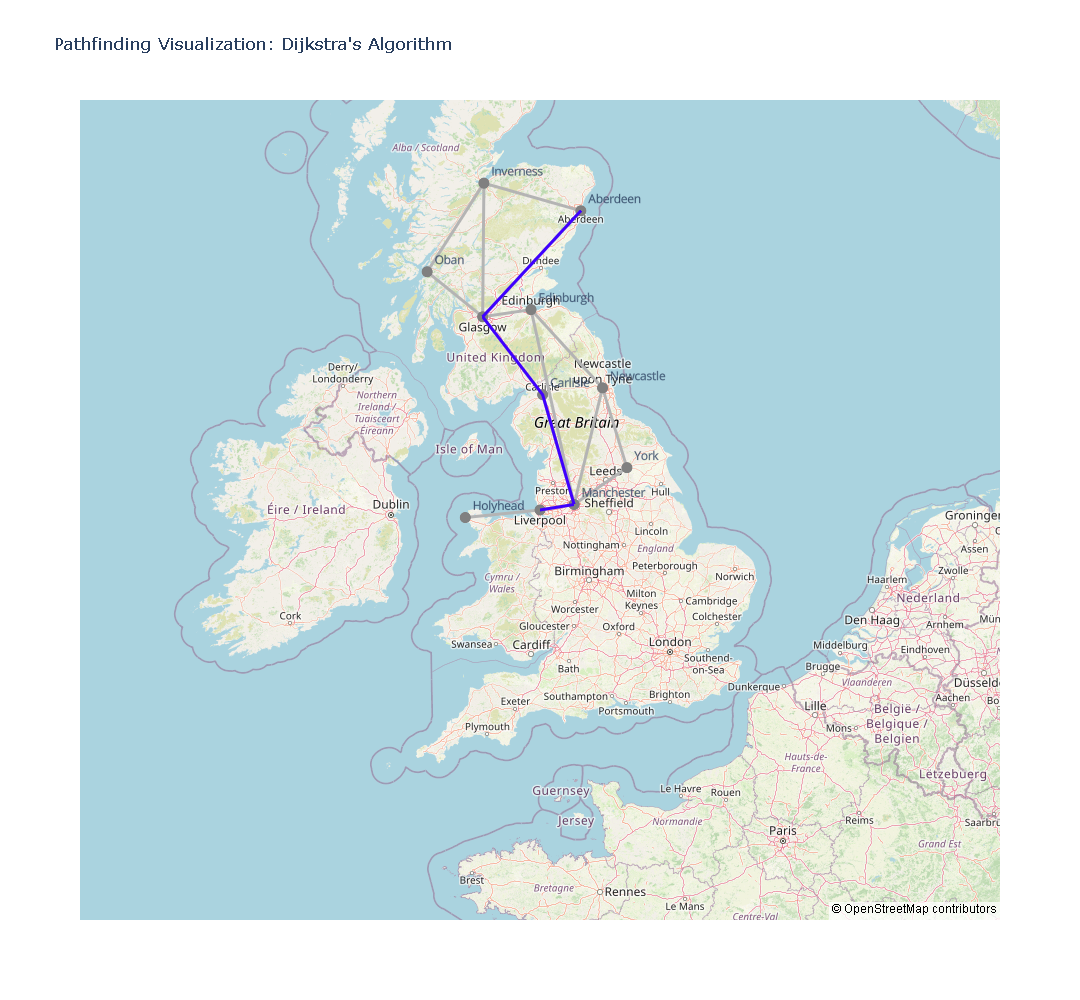


--- A* Algorithm ---

Path: ['Liverpool', 'Manchester', 'Carlisle', 'Glasgow', 'Aberdeen']


--- Traffic Conditions ---
Liverpool -> Manchester: No Traffic
Manchester -> Carlisle: No Traffic
Carlisle -> Glasgow: No Traffic
Glasgow -> Aberdeen: No Traffic
Distance: 400.00 miles

ETA for Bicycle: 33.33 hours
Bicycle Emissions: 0.00 Kg CO₂

ETA for Ev: 6.67 hours
Ev Emissions: 36.00 Kg CO₂

ETA for Petrol_car: 5.71 hours
Petrol_car Emissions: 84.40 Kg CO₂



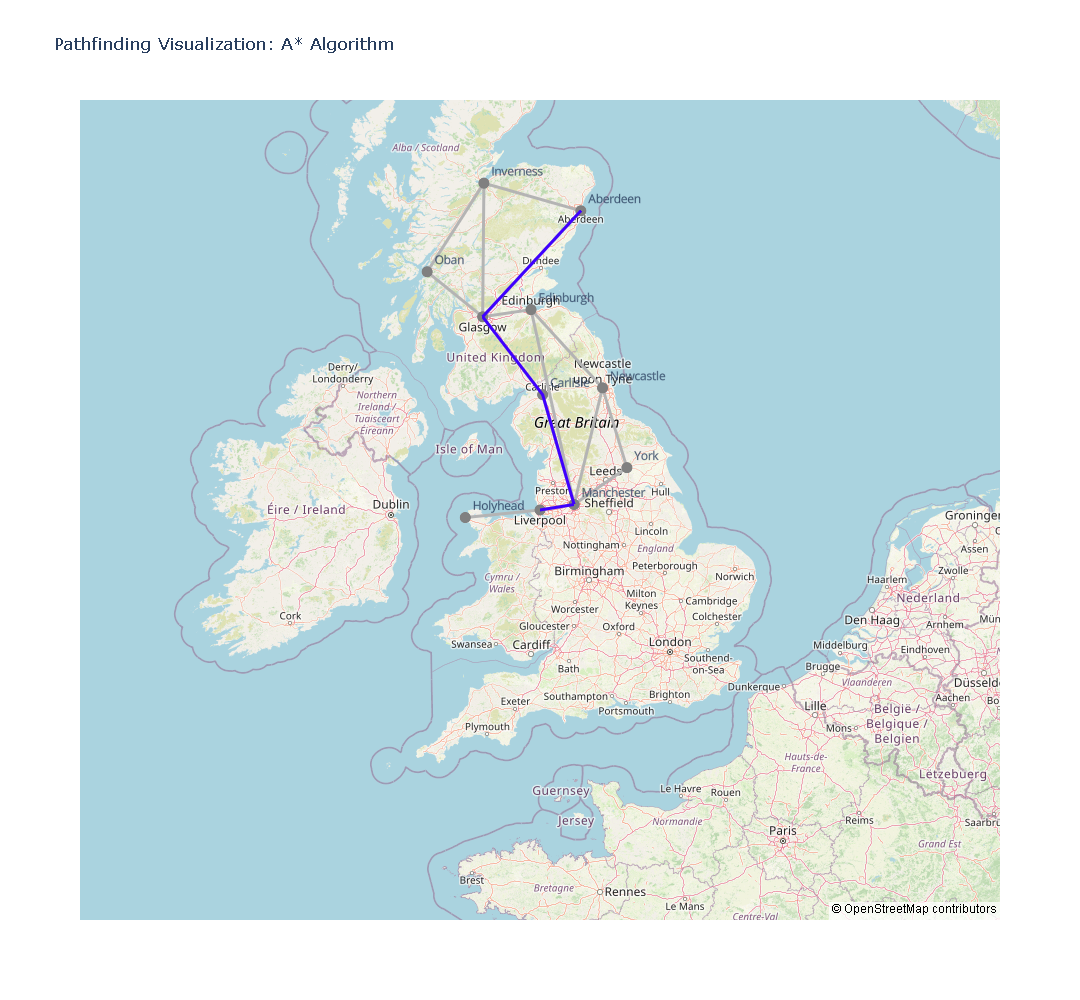


--- Breadth-First Search (BFS) ---

Path: ['Liverpool', 'Manchester', 'Edinburgh', 'Glasgow', 'Aberdeen']


--- Traffic Conditions ---
Liverpool -> Manchester: No Traffic
Manchester -> Edinburgh: No Traffic
Edinburgh -> Glasgow: No Traffic
Glasgow -> Aberdeen: No Traffic
Distance: 440.00 miles

ETA for Bicycle: 36.67 hours
Bicycle Emissions: 0.00 Kg CO₂

ETA for Ev: 7.33 hours
Ev Emissions: 39.60 Kg CO₂

ETA for Petrol_car: 6.29 hours
Petrol_car Emissions: 92.84 Kg CO₂



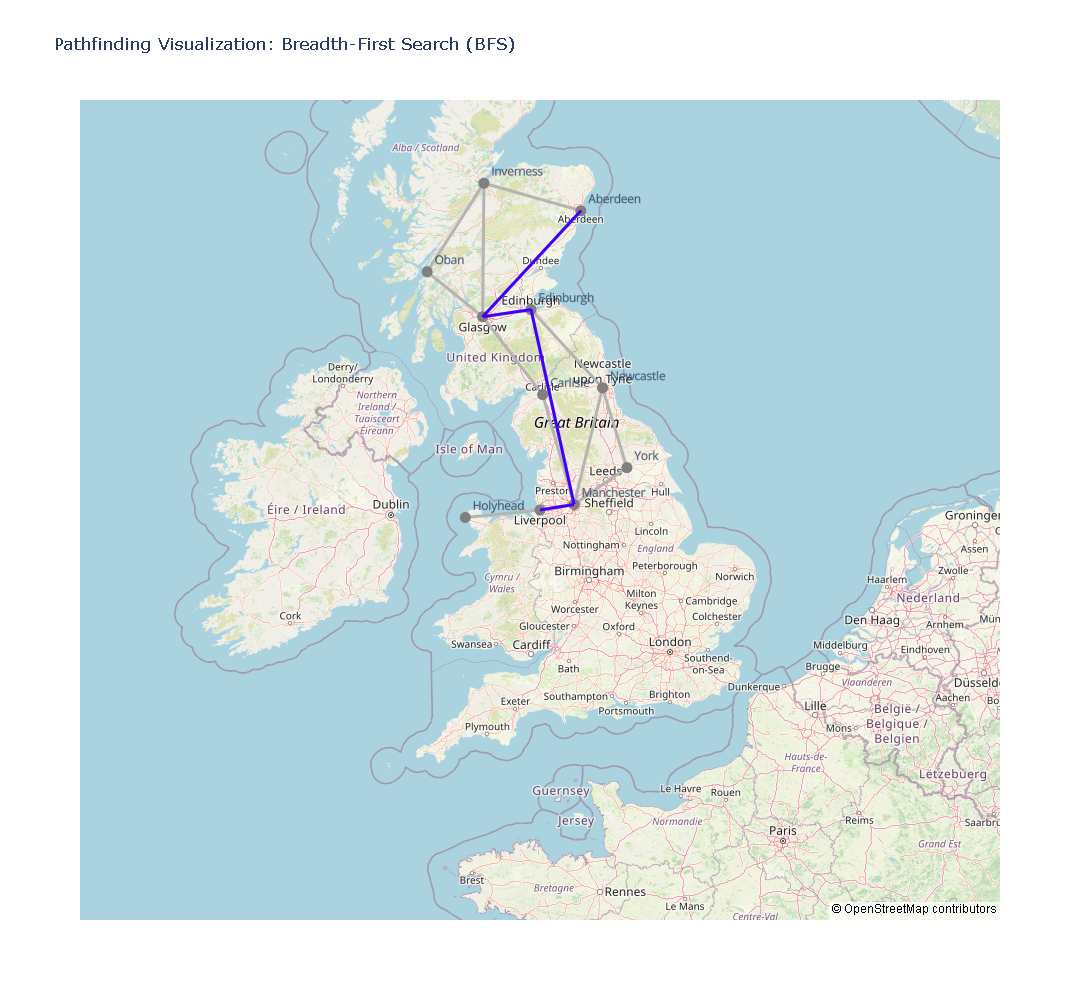


--- Depth-First Search (DFS) ---

Path: ['Liverpool', 'Manchester', 'Carlisle', 'Glasgow', 'Aberdeen']


--- Traffic Conditions ---
Liverpool -> Manchester: No Traffic
Manchester -> Carlisle: No Traffic
Carlisle -> Glasgow: No Traffic
Glasgow -> Aberdeen: No Traffic
Distance: 400.00 miles

ETA for Bicycle: 33.33 hours
Bicycle Emissions: 0.00 Kg CO₂

ETA for Ev: 6.67 hours
Ev Emissions: 36.00 Kg CO₂

ETA for Petrol_car: 5.71 hours
Petrol_car Emissions: 84.40 Kg CO₂



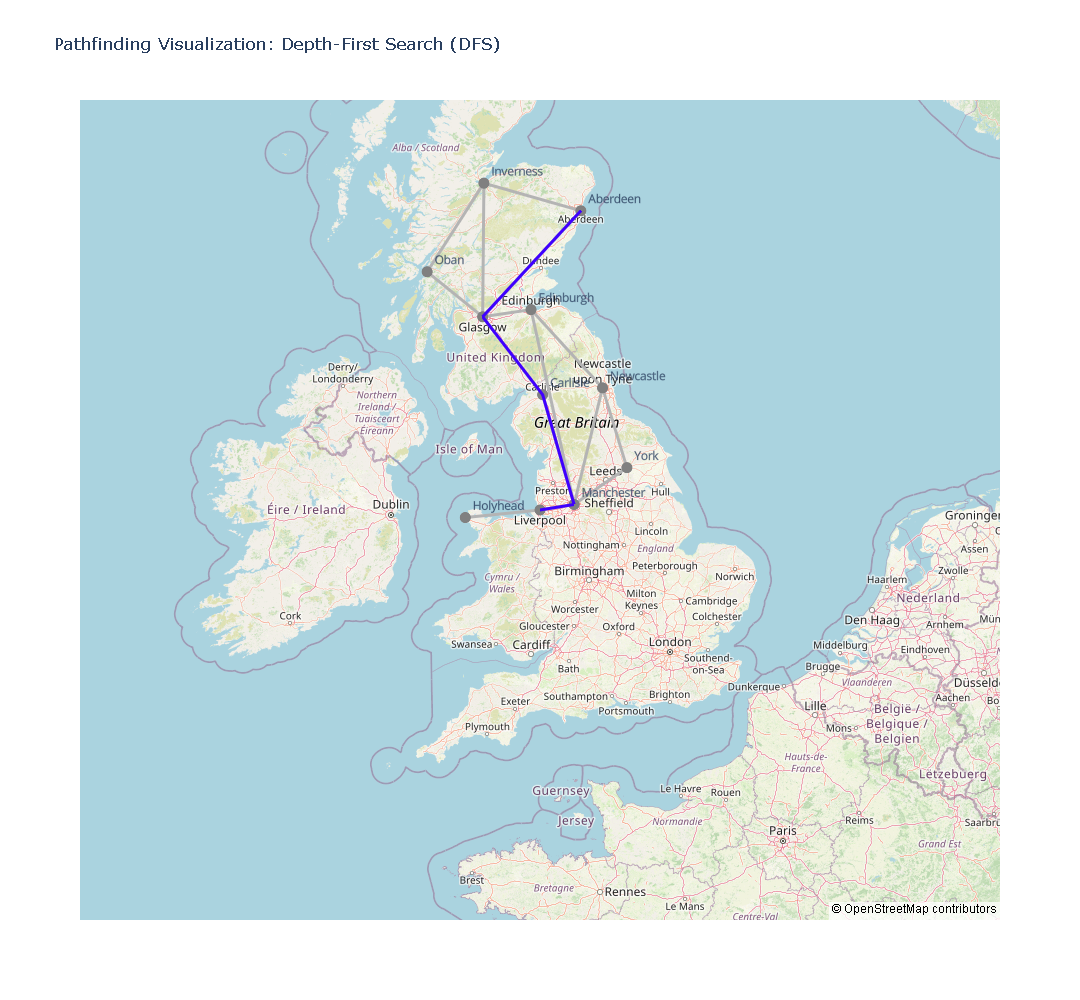

In [42]:


# Main function to run the program
def main():
    # Initialize environment and agent
    env = Environment()
    agent = Search(env)

    # Display the list of cities
    cities = env.get_cities()
    print("List of cities:")
    for i, city in enumerate(cities, 1):
        print(f"{i}. {city}")

    # Get start and end cities from the user
    try:
        start_city_index = int(input(f"Enter the number for the start city (1-{len(cities)}): ")) - 1
        end_city_index = int(input(f"Enter the number for the end city (1-{len(cities)}): ")) - 1

        if start_city_index < 0 or start_city_index >= len(cities) or end_city_index < 0 or end_city_index >= len(cities):
            print("Invalid city number entered. Please try again.")
            return

        start_city = cities[start_city_index]
        end_city = cities[end_city_index]
        print(f"Start city: {start_city}, End city: {end_city}")

        # Run all algorithms and display results
        algorithms = {
            "Dijkstra's Algorithm": agent.dijkstra,
            "A* Algorithm": agent.astar,
            "Breadth-First Search (BFS)": agent.bfs,
            "Depth-First Search (DFS)": agent.dfs
        }

        for algorithm_name, algorithm_func in algorithms.items():
            #print(f"\n--- {algorithm_name} ---")
            path = algorithm_func(start_city, end_city)
            if path:
                visualize_path(env, path, algorithm_name)
            else:
                print("No path found.")

    except ValueError:
        print("Please enter valid numbers.")


# Run the programb
if __name__ == "__main__":
    main()